# Experiments 1-3. Location-specific bias analysis.
Generates __Figure 5__ in the manuscript.

In [1]:
rm(list=ls())

In [10]:
library(dplyr)
library(binom)
library(ggplot2)

## First, finding observers that participated at least in two experiments

In [3]:
# finding observers that participated in both experiments
exp1 <-list.files(path= 'Experiment 1', pattern= '*.csv')
exp1 <- tolower(regmatches(exp1, regexpr('[[:alpha:]]{3}[[:digit:]]{2,4}[[:alpha:]]', exp1)))
exp2 <- list.files(path= 'Experiment 2', pattern= '*.csv')
exp2 <- tolower(regmatches(exp2, regexpr('[[:alpha:]]{3}[[:digit:]]{2,4}[[:alpha:]]', exp2)))
exp3 <- list.files(path= 'Experiment 3', pattern= '*blink.csv')
exp3 <- tolower(regmatches(exp3, regexpr('[[:alpha:]]{3}[[:digit:]]{2,4}[[:alpha:]]', exp3)))
participation <- data.frame(table(c(exp1, exp2, exp3)))
participation <- subset(participation, Freq>1)
common.participants <- participation$Var1
common.participants <- setdiff(common.participants, c('bpm1997w'))  # excluding BPM1997w, as she has very strong bias
common.participants

[1] "azm1990w" "cen2000w" "egn1994m" "ikb1995w" "phm1988w" "sda1995m" "skl1994w"
[8] "uks1989m"

## Loading data from all experiments into a single table

In [4]:
condition.columns <- c('sfmWidth', 'showHalo', 'playSound', 'Occluder', 'Color', 'Condition', 'Blink')
results <- data.frame()

for(current.participant in common.participants){
    cat(current.participant, '\n')
    for(current.experiment in c('Experiment 1', 'Experiment 2', 'Experiment 3')){
        # checking if file(s) exists for that specific experiment and loading them
        current.observer <- data.frame()
        if (current.experiment!= 'Experiment 3') {
            filename <- list.files(path= current.experiment, pattern= sprintf('.*%s.*csv$', current.participant), ignore.case = TRUE)
            if (length(filename)>0){
                cat('  ', current.experiment, ': ', filename, '\n', sep='')
                
                # loading the file
                current.observer <- read.csv2(file.path(current.experiment, filename))
            }
        }
        else {
            file.blink <- list.files(path= current.experiment, pattern= sprintf('.*%s.*blink[.]csv$', current.participant), ignore.case = TRUE)
            file.sound <- list.files(path= current.experiment, pattern= sprintf('.*%s.*sound[.]csv$', current.participant), ignore.case = TRUE)
            if ((length(file.blink)>0) & (length(file.sound)>0)){
                # loading and merging files
                current.blink <- read.csv2(file.path(current.experiment, file.blink))
                current.sound <- read.csv2(file.path(current.experiment, file.sound))
                current.observer <- rbind(current.blink, current.sound)
            }
            
        }
        
        # skipping empty combinations
        if (nrow(current.observer) == 0){
            next;
        }
        

        # making sure that observer codes are uniform
        current.observer$Observer <- current.participant
        
        # adding experiment info
        current.observer$Experiment <- current.experiment

        # correcting any rounding errors on the RelativeLocation
        current.observer$RelativeLocation[which(current.observer$RelativeLocation< -1)]<- -1
        current.observer$RelativeLocation[current.observer$RelativeLocation> 1]<-  1

        # adding trial index (time between two extremeties)
        current.observer$Trial <- NA
        for(current.block in unique(current.observer$Block)){
            iTrialStartEnd <- which((current.observer$Block==current.block) &  
                                     current.observer$Event %in% c('Block start', 'Trajectory limit', 'Block end'))

            for(iCurrentTrial in 1:(length(iTrialStartEnd)-1)){
                current.observer$Trial[iTrialStartEnd[iCurrentTrial]:iTrialStartEnd[iCurrentTrial+1]]<- iCurrentTrial
            }
        }
        
        # dropping condition columns, as they differ between experiments
        current.observer<- current.observer[, setdiff(colnames(current.observer), condition.columns)]        

        # binding tables
        results <- rbind(results, current.observer)
    }
}


# being tidy
rm(list=setdiff(ls(), "results"))      

azm1990w 
  Experiment 1: AZM1990w.csv
  Experiment 2: AZM1990w.csv
cen2000w 
  Experiment 1: CEN2000w.csv
  Experiment 2: CEN2000w.csv
egn1994m 
  Experiment 1: EGN1994m.csv
  Experiment 2: EGN1994m.csv
ikb1995w 
  Experiment 1: IKB1995w.csv
  Experiment 2: IKB1995w.csv
phm1988w 
  Experiment 1: PHM1988w.csv
  Experiment 2: PHM1988w.csv
sda1995m 
  Experiment 2: SDA1995M .csv
skl1994w 
  Experiment 1: SKL1994w.csv
  Experiment 2: SKL1994w.csv
uks1989m 
  Experiment 1: UKS1989m.csv
  Experiment 2: UKS1989m.csv


## For each observer, we bin the trajectory and count the fraction of "up" reports

In [5]:
# counting trials for each observers
trial.count <- results %>%
    group_by(Observer, Block, Trial) %>%
    summarise() %>%
    group_by(Observer) %>%
    summarise(Trials= n())

# preparing counters for each observer and each bin
bins<- seq(-1,1,0.05)
counter <- data.frame(expand.grid(unique(results$Observer), bins, c('Experiment 1', 'Experiment 2', 'Experiment 3'), NA))
colnames(counter)<- c('Observer', 'RelativeLocation', 'Experiment', 'Count')
counter$Count <- as.numeric(counter$Count)
up.count <- counter
down.count <- counter

In [6]:
# laying out probability of perceiving "up" for each trial and location
for(current.observer in unique(results$Observer)){
    observer.data <- subset(results, Observer==current.observer)
    for(current.experiment in unique(results$Experiment)){
        experiment.data <- subset(observer.data, Experiment== current.experiment)
        for(current.block in unique(experiment.data$Block)){
            block.data <- subset(experiment.data, Block==current.block)
            last.percept.on.previous.trial <- NA

            for(current.trial in unique(block.data$Trial))
            {
                trial.perception<- rep(0, length(bins))

                # picking only percept reports
                trial.data <- subset(block.data, (Trial==current.trial) & (Event=='Percept'))
                trial.data$Value <- as.numeric(trial.data$Value)
                if (nrow(trial.data)>0){
                    for(iEvent in 1:nrow(trial.data)){
                        if (trial.data$Direction[iEvent]>0){
                            iBins <- which(bins>trial.data$RelativeLocation[[iEvent]])
                        }
                        else {
                            iBins <- which(bins<trial.data$RelativeLocation[[iEvent]])
                        }
                        trial.perception[iBins] <- trial.data$Value[iEvent]
                    }
                    last.percept.on.previous.trial <- trial.data$Value[nrow(trial.data)]
                }
                else {
                    if (is.finite(last.percept.on.previous.trial)){
                        trial.perception <- rep(last.percept.on.previous.trial, length(bins))
                    }
                }

                # leaving only the "up" percept
                up.perception<- trial.perception
                up.perception[up.perception<0] <- 0 
                if (is.na(up.count$Count[(up.count$Observer==current.observer) & (up.count$Experiment==current.experiment)][1])){
                    up.count$Count[(up.count$Observer==current.observer) & (up.count$Experiment==current.experiment)]<- up.perception
                }
                else{
                    up.count$Count[(up.count$Observer==current.observer) & (up.count$Experiment==current.experiment)] <- up.count$Count[(up.count$Observer==current.observer) & (up.count$Experiment==current.experiment)]+up.perception
                }

                # leaving only the "down" percept
                down.perception<- trial.perception
                down.perception[down.perception>0] <- 0             
                if (is.na(down.count$Count[(down.count$Observer==current.observer) & (down.count$Experiment==current.experiment)][1])){
                    down.count$Count[(down.count$Observer==current.observer) & (down.count$Experiment==current.experiment)] <- -down.perception
                }
                else {
                    down.count$Count[(down.count$Observer==current.observer) & (down.count$Experiment==current.experiment)] <- down.count$Count[(down.count$Observer==current.observer) & (down.count$Experiment==current.experiment)]-down.perception
                }
            }
        }
    }
}

# adding info about the total trial count
up.count$Trials <- up.count$Count+down.count$Count
down.count$Trials <- up.count$Count+down.count$Count

# dropping empty rows (for experiments that participant was not a part of)
up.count <- na.omit(up.count)
down.count <- na.omit(down.count)

In [7]:
# computing an overall mean
P.up.mean <- up.count %>%
    group_by(Observer, Experiment) %>%
    summarise(up= mean(Count/Trials))
P.down.mean <- down.count %>%
    group_by(Observer, Experiment) %>%
    summarise(down= mean(Count/Trials))
P.overall.mean <- merge(P.up.mean, P.down.mean, by=c('Observer', 'Experiment'))

In [8]:
# computing mean and confidence interval for each bin
up.count.ci <- up.count %>%
    transform(P.mean= Count/Trials,
              P.ci.lower = binom.bayes(Count, Trials)$lower,
              P.ci.upper = binom.bayes(Count, Trials)$upper)
up.count.ci <- merge(up.count.ci, P.overall.mean, by=c('Observer', 'Experiment'))

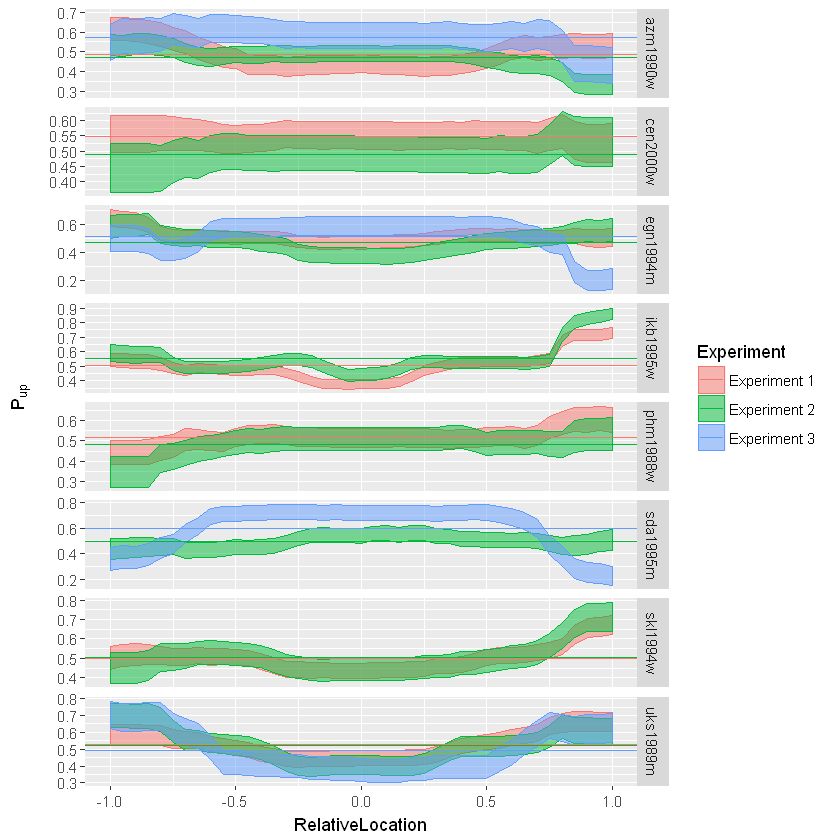

In [9]:
location.plot <- ggplot(data= up.count.ci, #[up.count.ci$Observer=='BPM1997w', ],
                        aes(x= RelativeLocation, y= P.mean, 
                            ymin= P.ci.lower, ymax=P.ci.upper,
                            group= Experiment, fill=Experiment, color=Experiment))+
    facet_grid(Observer~., scales="free_y") + 
    scale_x_continuous(limits=c(-1, 1))+
    geom_ribbon(alpha= 0.5)+
    geom_hline(aes(yintercept = up, color= Experiment), data= P.overall.mean)+
    ylab(expression(P[up]))
print(location.plot)
ggsave(file="Experiments 1-3 - location-specific percept.pdf", plot= location.plot, width= 16, height= 24, units = 'cm')